In [ ]:
import cv2
from matplotlib import pyplot as plt
image_name = "lena.jpg"
kernel_size=(9,9)
sigma=50

img1=cv2.imread(image_name)
b, g, r = cv2.split(img1)
img= cv2.merge([r,g,b])

plt.subplot(121)
plt.imshow(img)

blur = cv2.GaussianBlur(img,kernel_size,sigma)
plt.subplot(122)
plt.imshow(blur)
plt.show()



In [ ]:
import math
import numpy as np
#二维卷积
def conv2d(img,kernel):
    #padding
    height = img.shape[0]
    width = img.shape[1]
    #kernel size为奇数
    padding_size = kernel.shape[0] // 2
    img_padding = np.zeros(shape =(height+2*padding_size,width+2*padding_size))
    img_padding[padding_size:padding_size+height,padding_size:padding_size+width] = img
    result = np.zeros(shape=(height,width))
    for i in range(height):
        for j in range(width):
            conv_result = np.multiply(kernel,img_padding[i:i+2*padding_size+1,j:j+2*padding_size+1])
            result[i][j] = conv_result.sum()
    return result

a = np.array([[1,1,1],[1,1,1],[1,1,1]])
b = np.ones(shape=[5,5])

print conv2d(b,a)




In [ ]:
#源码实现高斯模糊
#只能输入灰度图
#不知道彩色图的高斯模糊的策略是什么
from __future__ import division
import math
import numpy as np

#二维卷积
def conv2d(img,kernel):
    #padding
    height = img.shape[0]
    width = img.shape[1]
    #kernel size为奇数
    padding_size = kernel.shape[0] // 2
    img_padding = np.zeros(shape =(height+2*padding_size,width+2*padding_size))
    img_padding[padding_size:padding_size+height,padding_size:padding_size+width] = img
    result = np.zeros(shape=(height,width))
    for i in range(height):
        for j in range(width):
            conv_result = np.multiply(kernel,img_padding[i:i+2*padding_size+1,j:j+2*padding_size+1])
            result[i][j] = conv_result.sum()
    return result
class myGaussianBlur():
    def __init__(self,radius,sigma):
        self.radius = radius
        self.sigma = sigma
    #二维高斯函数
    def __gaussian__(self,x,y):
        res1 = 1/(2*math.pi*self.sigma**2)
        res2 = math.exp(-(x**2+y**2)/(2*self.sigma*self.sigma))
        return res1*res2
    #计算高斯模板
    def __template__(self):
        sideLength=self.radius*2+1  
        result = np.zeros((sideLength, sideLength))  
        for i in range(sideLength):  
            for j in range(sideLength):  
                result[i,j]=self.__gaussian__(i-self.radius, j-self.radius)  
        all=result.sum()  
        return result/all
    #使用模板与原始图像做卷积操作
    def filter(self,img):
        template = self.__template__()
        result = np.zeros(shape=img.shape)
        #for i in range(img.shape[-1]):
        result = conv2d(img,template)
        return result

if __name__=="__main__":
    radius = 11
    sigma = 10
    
    gaussianBlur = myGaussianBlur(radius,sigma)
    img=cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
    #b, g, r = cv2.split(img)
    #img= cv2.merge([r,g,b])
    plt.subplot(121)
    plt.imshow(img,cmap='gray')
    blur = gaussianBlur.filter(img)
    plt.subplot(122)
    #b, g, r = cv2.split(blur)
    plt.imshow(blur,cmap='gray')
    plt.show()

(1123, 128)


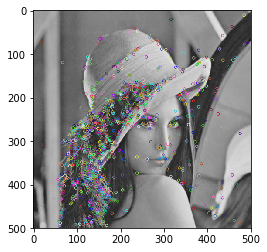

In [2]:
import cv2
from matplotlib import pyplot as plt
def getSift():  
    ''''' 
    得到并查看sift特征 
    '''  
    img_path1 = 'lena.jpg'  
    #读取图像  
    img = cv2.imread(img_path1)  
    #转换为灰度图  
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    #创建sift的类  
    sift = cv2.xfeatures2d.SIFT_create()
    #在图像中找到关键点 也可以一步计算#kp, des = sift.detectAndCompute  
    kp = sift.detect(gray,None)  
    #print type(kp),type(kp[0])  
    #Keypoint数据类型分析 http://www.cnblogs.com/cj695/p/4041399.html  
    #print kp[0].pt  
    #计算每个点的sift  
    des = sift.compute(gray,kp)  
    #print type(kp),type(des)  
    #des[0]为关键点的list，des[1]为特征向量的矩阵  
    #print type(des[0]), type(des[1])  
    #print des[0],des[1]  
    #可以看出共有885个sift特征，每个特征为128维  
    print des[1].shape  
    #在灰度图中画出这些点  
    img=cv2.drawKeypoints(gray,kp,img)  
    #cv2.imwrite('sift_keypoints.jpg',img)  
    plt.imshow(img),plt.show()
    
getSift()

In [1]:
import numpy as np
from scipy import signal
from scipy import misc
from scipy import ndimage
from scipy.stats import multivariate_normal
from numpy.linalg import norm
import numpy.linalg

# INPUTS: imagename (filename of image, string) 
#         threshold (constrast threshold, int or float)
# OUTPUT: keypoints (an array of four column, where the first is the x location, the second is the y location, the third is the scale, and the fourth is the orientation)
#         descriptors (an array of 128 columns, which correspond to the SIFT descriptor)

def detect_keypoints(imagename, threshold):
    # SIFT Detector 
    #--------------
     
    original = ndimage.imread(imagename, flatten=True)

    # SIFT Parameters
    s = 3
    k = 2 ** (1.0 / s)
    # threshold variable is the contrast threshold. Set to at least 1

    # Standard deviations for Gaussian smoothing
    kvec1 = np.array([1.3, 1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4)])
    kvec2 = np.array([1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7)])
    kvec3 = np.array([1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10)])
    kvec4 = np.array([1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11), 1.6 * (k ** 12), 1.6 * (k ** 13)])
    kvectotal = np.array([1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11)])

    # Downsampling images
    doubled = misc.imresize(original, 200, 'bilinear').astype(int)
    normal = misc.imresize(doubled, 50, 'bilinear').astype(int)
    halved = misc.imresize(normal, 50, 'bilinear').astype(int)
    quartered = misc.imresize(halved, 50, 'bilinear').astype(int)

    # Initialize Gaussian pyramids
    pyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 6))
    pyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 6))
    pyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 6))
    pyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 6))

    print "Constructing pyramids..."

    # Construct Gaussian pyramids
    for i in range(0, 6):
        pyrlvl1[:,:,i] = ndimage.filters.gaussian_filter(doubled, kvec1[i])   
        pyrlvl2[:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(doubled, kvec2[i]), 50, 'bilinear') 
        pyrlvl3[:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(doubled, kvec3[i]), 25, 'bilinear')
        pyrlvl4[:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(doubled, kvec4[i]), 1.0 / 8.0, 'bilinear')

    # Initialize Difference-of-Gaussians (DoG) pyramids
    diffpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 5))
    diffpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 5))
    diffpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 5))
    diffpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 5))

    # Construct DoG pyramids
    for i in range(0, 5):
        diffpyrlvl1[:,:,i] = pyrlvl1[:,:,i+1] - pyrlvl1[:,:,i]
        diffpyrlvl2[:,:,i] = pyrlvl2[:,:,i+1] - pyrlvl2[:,:,i]
        diffpyrlvl3[:,:,i] = pyrlvl3[:,:,i+1] - pyrlvl3[:,:,i]
        diffpyrlvl4[:,:,i] = pyrlvl4[:,:,i+1] - pyrlvl4[:,:,i]

    # Initialize pyramids to store extrema locations
    extrpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 3))
    extrpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 3))
    extrpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 3))
    extrpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 3))

    print "Starting extrema detection..."
    print "First octave"

    # In each of the following for loops, elements of each pyramids that are larger or smaller than its 26 immediate neighbors in space and scale are labeled as extrema. As explained in section 4 of Lowe's paper, these initial extrema are pruned by checking that their contrast and curvature are above certain thresholds. The thresholds used here are those suggested by Lowe. 

    for i in range(1, 4):
        for j in range(80, doubled.shape[0] - 80):
            for k in range(80, doubled.shape[1] - 80):
                if np.absolute(diffpyrlvl1[j, k, i]) < threshold:
                    continue

                maxbool = (diffpyrlvl1[j, k, i] > 0)
                minbool = (diffpyrlvl1[j, k, i] < 0)

		for di in range(-1, 2):
		    for dj in range(-1, 2):
			for dk in range(-1, 2):
			    if di == 0 and dj == 0 and dk == 0:
				continue
			    maxbool = maxbool and (diffpyrlvl1[j, k, i] > diffpyrlvl1[j + dj, k + dk, i + di])
			    minbool = minbool and (diffpyrlvl1[j, k, i] < diffpyrlvl1[j + dj, k + dk, i + di])
			    if not maxbool and not minbool:
				break

			if not maxbool and not minbool:
			    break

		    if not maxbool and not minbool:
			break
		
		if maxbool or minbool:
		    dx = (diffpyrlvl1[j, k+1, i] - diffpyrlvl1[j, k-1, i]) * 0.5 / 255
		    dy = (diffpyrlvl1[j+1, k, i] - diffpyrlvl1[j-1, k, i]) * 0.5 / 255
		    ds = (diffpyrlvl1[j, k, i+1] - diffpyrlvl1[j, k, i-1]) * 0.5 / 255
		    dxx = (diffpyrlvl1[j, k+1, i] + diffpyrlvl1[j, k-1, i] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255        
		    dyy = (diffpyrlvl1[j+1, k, i] + diffpyrlvl1[j-1, k, i] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255          
		    dss = (diffpyrlvl1[j, k, i+1] + diffpyrlvl1[j, k, i-1] - 2 * diffpyrlvl1[j, k, i]) * 1.0 / 255
		    dxy = (diffpyrlvl1[j+1, k+1, i] - diffpyrlvl1[j+1, k-1, i] - diffpyrlvl1[j-1, k+1, i] + diffpyrlvl1[j-1, k-1, i]) * 0.25 / 255 
		    dxs = (diffpyrlvl1[j, k+1, i+1] - diffpyrlvl1[j, k-1, i+1] - diffpyrlvl1[j, k+1, i-1] + diffpyrlvl1[j, k-1, i-1]) * 0.25 / 255 
		    dys = (diffpyrlvl1[j+1, k, i+1] - diffpyrlvl1[j-1, k, i+1] - diffpyrlvl1[j+1, k, i-1] + diffpyrlvl1[j-1, k, i-1]) * 0.25 / 255  
		    
		    dD = np.matrix([[dx], [dy], [ds]])
		    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
		    x_hat = numpy.linalg.lstsq(H, dD)[0]
		    D_x_hat = diffpyrlvl1[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)
		 
		    r = 10.0
		    if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and 
            (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) 
            and (np.absolute(D_x_hat) > 0.03):
			extrpyrlvl1[j, k, i - 1] = 1

    print "Second octave"

    for i in range(1, 4):
	for j in range(40, normal.shape[0] - 40):
	    for k in range(40, normal.shape[1] - 40):
		if np.absolute(diffpyrlvl2[j, k, i]) < threshold:
		    continue	    

		maxbool = (diffpyrlvl2[j, k, i] > 0)
		minbool = (diffpyrlvl2[j, k, i] < 0)
		
		for di in range(-1, 2):
		    for dj in range(-1, 2):
			for dk in range(-1, 2):
			    if di == 0 and dj == 0 and dk == 0:
				continue
			    maxbool = maxbool and (diffpyrlvl2[j, k, i] > diffpyrlvl2[j + dj, k + dk, i + di])
			    minbool = minbool and (diffpyrlvl2[j, k, i] < diffpyrlvl2[j + dj, k + dk, i + di])
			    if not maxbool and not minbool:
				break

			if not maxbool and not minbool:
			    break

		    if not maxbool and not minbool:
			break
		
        if maxbool or minbool:
            dx = (diffpyrlvl2[j, k+1, i] - diffpyrlvl2[j, k-1, i]) * 0.5 / 255
            dy = (diffpyrlvl2[j+1, k, i] - diffpyrlvl2[j-1, k, i]) * 0.5 / 255
            ds = (diffpyrlvl2[j, k, i+1] - diffpyrlvl2[j, k, i-1]) * 0.5 / 255
            dxx = (diffpyrlvl2[j, k+1, i] + diffpyrlvl2[j, k-1, i] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255        
            dyy = (diffpyrlvl2[j+1, k, i] + diffpyrlvl2[j-1, k, i] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255          
            dss = (diffpyrlvl2[j, k, i+1] + diffpyrlvl2[j, k, i-1] - 2 * diffpyrlvl2[j, k, i]) * 1.0 / 255
            dxy = (diffpyrlvl2[j+1, k+1, i] - diffpyrlvl2[j+1, k-1, i] - diffpyrlvl2[j-1, k+1, i] + diffpyrlvl2[j-1, k-1, i]) * 0.25 / 255 
            dxs = (diffpyrlvl2[j, k+1, i+1] - diffpyrlvl2[j, k-1, i+1] - diffpyrlvl2[j, k+1, i-1] + diffpyrlvl2[j, k-1, i-1]) * 0.25 / 255 
            dys = (diffpyrlvl2[j+1, k, i+1] - diffpyrlvl2[j-1, k, i+1] - diffpyrlvl2[j+1, k, i-1] + diffpyrlvl2[j-1, k, i-1]) * 0.25 / 255  

            dD = np.matrix([[dx], [dy], [ds]])
            H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
            x_hat = numpy.linalg.lstsq(H, dD)[0]
            D_x_hat = diffpyrlvl2[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

            r = 10.0
            if (((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
                extrpyrlvl2[j, k, i - 1] = 1

    print "Third octave"
      
    for i in range(1, 4):
	for j in range(20, halved.shape[0] - 20):
	    for k in range(20, halved.shape[1] - 20):
		if np.absolute(diffpyrlvl3[j, k, i]) < threshold:
		    continue	    

		maxbool = (diffpyrlvl3[j, k, i] > 0)
		minbool = (diffpyrlvl3[j, k, i] < 0)
		
		for di in range(-1, 2):
		    for dj in range(-1, 2):
			for dk in range(-1, 2):
			    if di == 0 and dj == 0 and dk == 0:
				continue
			    maxbool = maxbool and (diffpyrlvl3[j, k, i] > diffpyrlvl3[j + dj, k + dk, i + di])
			    minbool = minbool and (diffpyrlvl3[j, k, i] < diffpyrlvl3[j + dj, k + dk, i + di])
			    if not maxbool and not minbool:
				break

			if not maxbool and not minbool:
			    break

		    if not maxbool and not minbool:
			break
		
		if maxbool or minbool:
		    dx = (diffpyrlvl3[j, k+1, i] - diffpyrlvl3[j, k-1, i]) * 0.5 / 255
		    dy = (diffpyrlvl3[j+1, k, i] - diffpyrlvl3[j-1, k, i]) * 0.5 / 255
		    ds = (diffpyrlvl3[j, k, i+1] - diffpyrlvl3[j, k, i-1]) * 0.5 / 255
		    dxx = (diffpyrlvl3[j, k+1, i] + diffpyrlvl3[j, k-1, i] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255        
		    dyy = (diffpyrlvl3[j+1, k, i] + diffpyrlvl3[j-1, k, i] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255          
		    dss = (diffpyrlvl3[j, k, i+1] + diffpyrlvl3[j, k, i-1] - 2 * diffpyrlvl3[j, k, i]) * 1.0 / 255
		    dxy = (diffpyrlvl3[j+1, k+1, i] - diffpyrlvl3[j+1, k-1, i] - diffpyrlvl3[j-1, k+1, i] + diffpyrlvl3[j-1, k-1, i]) * 0.25 / 255 
		    dxs = (diffpyrlvl3[j, k+1, i+1] - diffpyrlvl3[j, k-1, i+1] - diffpyrlvl3[j, k+1, i-1] + diffpyrlvl3[j, k-1, i-1]) * 0.25 / 255 
		    dys = (diffpyrlvl3[j+1, k, i+1] - diffpyrlvl3[j-1, k, i+1] - diffpyrlvl3[j+1, k, i-1] + diffpyrlvl3[j-1, k, i-1]) * 0.25 / 255  
		    
		    dD = np.matrix([[dx], [dy], [ds]])
		    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
		    x_hat = numpy.linalg.lstsq(H, dD)[0]
		    D_x_hat = diffpyrlvl3[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

		    r = 10.0
		    if (((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
			extrpyrlvl3[j, k, i - 1] = 1
		    
		      
    print "Fourth octave"

    for i in range(1, 4):
	for j in range(10, quartered.shape[0] - 10):
	    for k in range(10, quartered.shape[1] - 10):
		if np.absolute(diffpyrlvl4[j, k, i]) < threshold:
		    continue	    

		maxbool = (diffpyrlvl4[j, k, i] > 0)
		minbool = (diffpyrlvl4[j, k, i] < 0)
		
		for di in range(-1, 2):
		    for dj in range(-1, 2):
			for dk in range(-1, 2):
			    if di == 0 and dj == 0 and dk == 0:
				continue
			    maxbool = maxbool and (diffpyrlvl4[j, k, i] > diffpyrlvl4[j + dj, k + dk, i + di])
			    minbool = minbool and (diffpyrlvl4[j, k, i] < diffpyrlvl4[j + dj, k + dk, i + di])
			    if not maxbool and not minbool:
				break

			if not maxbool and not minbool:
			    break

		    if not maxbool and not minbool:
			break
		
		if maxbool or minbool:
		    dx = (diffpyrlvl4[j, k+1, i] - diffpyrlvl4[j, k-1, i]) * 0.5 / 255
		    dy = (diffpyrlvl4[j+1, k, i] - diffpyrlvl4[j-1, k, i]) * 0.5 / 255
		    ds = (diffpyrlvl4[j, k, i+1] - diffpyrlvl4[j, k, i-1]) * 0.5 / 255
		    dxx = (diffpyrlvl4[j, k+1, i] + diffpyrlvl4[j, k-1, i] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255        
		    dyy = (diffpyrlvl4[j+1, k, i] + diffpyrlvl4[j-1, k, i] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255          
		    dss = (diffpyrlvl4[j, k, i+1] + diffpyrlvl4[j, k, i-1] - 2 * diffpyrlvl4[j, k, i]) * 1.0 / 255
		    dxy = (diffpyrlvl4[j+1, k+1, i] - diffpyrlvl4[j+1, k-1, i] - diffpyrlvl4[j-1, k+1, i] + diffpyrlvl4[j-1, k-1, i]) * 0.25 / 255 
		    dxs = (diffpyrlvl4[j, k+1, i+1] - diffpyrlvl4[j, k-1, i+1] - diffpyrlvl4[j, k+1, i-1] + diffpyrlvl4[j, k-1, i-1]) * 0.25 / 255 
		    dys = (diffpyrlvl4[j+1, k, i+1] - diffpyrlvl4[j-1, k, i+1] - diffpyrlvl4[j+1, k, i-1] + diffpyrlvl4[j-1, k, i-1]) * 0.25 / 255  
		    
		    dD = np.matrix([[dx], [dy], [ds]])
		    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
		    x_hat = numpy.linalg.lstsq(H, dD)[0]
		    D_x_hat = diffpyrlvl4[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

		    r = 10.0
		    if (((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
			extrpyrlvl4[j, k, i - 1] = 1
		     
	      
    print "Number of extrema in first octave: %d" % np.sum(extrpyrlvl1)
    print "Number of extrema in second octave: %d" % np.sum(extrpyrlvl2)
    print "Number of extrema in third octave: %d" % np.sum(extrpyrlvl3)
    print "Number of extrema in fourth octave: %d" % np.sum(extrpyrlvl4)
    
    # Gradient magnitude and orientation for each image sample point at each scale
    magpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 3))
    magpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 3))
    magpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 3))
    magpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 3))

    oripyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 3))
    oripyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 3))
    oripyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 3))
    oripyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 3))
    
    for i in range(0, 3):
        for j in range(1, doubled.shape[0] - 1):
            for k in range(1, doubled.shape[1] - 1):
                magpyrlvl1[j, k, i] = ( ((doubled[j+1, k] - doubled[j-1, k]) ** 2) + ((doubled[j, k+1] - doubled[j, k-1]) ** 2) ) ** 0.5   
                oripyrlvl1[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((doubled[j, k+1] - doubled[j, k-1]), (doubled[j+1, k] - doubled[j-1, k])))        
                
    for i in range(0, 3):
        for j in range(1, normal.shape[0] - 1):
            for k in range(1, normal.shape[1] - 1):
                magpyrlvl2[j, k, i] = ( ((normal[j+1, k] - normal[j-1, k]) ** 2) + ((normal[j, k+1] - normal[j, k-1]) ** 2) ) ** 0.5   
                oripyrlvl2[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((normal[j, k+1] - normal[j, k-1]), (normal[j+1, k] - normal[j-1, k])))    

    for i in range(0, 3):
        for j in range(1, halved.shape[0] - 1):
            for k in range(1, halved.shape[1] - 1):
                magpyrlvl3[j, k, i] = ( ((halved[j+1, k] - halved[j-1, k]) ** 2) + ((halved[j, k+1] - halved[j, k-1]) ** 2) ) ** 0.5   
                oripyrlvl3[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((halved[j, k+1] - halved[j, k-1]), (halved[j+1, k] - halved[j-1, k])))    

    for i in range(0, 3):
        for j in range(1, quartered.shape[0] - 1):
            for k in range(1, quartered.shape[1] - 1):
                magpyrlvl4[j, k, i] = ( ((quartered[j+1, k] - quartered[j-1, k]) ** 2) + ((quartered[j, k+1] - quartered[j, k-1]) ** 2) ) ** 0.5   
                oripyrlvl4[j, k, i] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((quartered[j, k+1] - quartered[j, k-1]), (quartered[j+1, k] - quartered[j-1, k])))    

    extr_sum = np.sum(extrpyrlvl1) + np.sum(extrpyrlvl2) + np.sum(extrpyrlvl3) + np.sum(extrpyrlvl4)
    type(extr_sum)
    keypoints = np.zeros((int(extr_sum), 4)) 

    print "Calculating keypoint orientations..."

    count = 0
    
    for i in range(0, 3):
        for j in range(80, doubled.shape[0] - 80):
            for k in range(80, doubled.shape[1] - 80):
                if extrpyrlvl1[j, k, i] == 1:
                    gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i]) ** 2))
                    two_sd = np.floor(2 * 1.5 * kvectotal[i])
                    orient_hist = np.zeros([36,1])
                    for x in range(int(-1 * two_sd * 2), int(two_sd * 2) + 1):
                        ylim = int((((two_sd * 2) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                        for y in range(-1 * ylim, ylim + 1):
                            if j + x < 0 or j + x > doubled.shape[0] - 1 or k + y < 0 or k + y > doubled.shape[1] - 1:
                                continue
                            weight = magpyrlvl1[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                            bin_idx = np.clip(np.floor(oripyrlvl1[j + x, k + y, i]), 0, 35)
                            orient_hist[np.floor(bin_idx)] += weight  
                    
                    maxval = np.amax(orient_hist)
                    maxidx = np.argmax(orient_hist)
                    keypoints[count, :] = np.array([int(j * 0.5), int(k * 0.5), kvectotal[i], maxidx])
                    count += 1
                    orient_hist[maxidx] = 0
                    newmaxval = np.amax(orient_hist)
                    while newmaxval > 0.8 * maxval:
                        newmaxidx = np.argmax(orient_hist)
                        np.append(keypoints, np.array([[int(j * 0.5), int(k * 0.5), kvectotal[i], newmaxidx]]), axis=0)
                        orient_hist[newmaxidx] = 0
                        newmaxval = np.amax(orient_hist)
    
                    
    for i in range(0, 3):
        for j in range(40, normal.shape[0] - 40):
            for k in range(40, normal.shape[1] - 40):
                if extrpyrlvl2[j, k, i] == 1:
                    gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i + 3]) ** 2))
                    two_sd = np.floor(2 * 1.5 * kvectotal[i + 3])
                    orient_hist = np.zeros([36,1])
                    for x in range(int(-1 * two_sd), int(two_sd + 1)):
                        ylim = int(((two_sd ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                        for y in range(-1 * ylim, ylim + 1):
                            if j + x < 0 or j + x > normal.shape[0] - 1 or k + y < 0 or k + y > normal.shape[1] - 1:
                                continue
                            weight = magpyrlvl2[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                            bin_idx = np.clip(np.floor(oripyrlvl2[j + x, k + y, i]), 0, 35)
                            orient_hist[np.floor(bin_idx)] += weight  
                    
                    maxval = np.amax(orient_hist)
                    maxidx = np.argmax(orient_hist)
                    keypoints[count, :] = np.array([j, k, kvectotal[i + 3], maxidx])
                    count += 1
                    orient_hist[maxidx] = 0
                    newmaxval = np.amax(orient_hist)
                    while newmaxval > 0.8 * maxval:
                        newmaxidx = np.argmax(orient_hist)
                        np.append(keypoints, np.array([[j, k, kvectotal[i + 3], newmaxidx]]), axis=0)
                        orient_hist[newmaxidx] = 0
                        newmaxval = np.amax(orient_hist)
    

    for i in range(0, 3):
        for j in range(20, halved.shape[0] - 20):
            for k in range(20, halved.shape[1] - 20):
                if extrpyrlvl3[j, k, i] == 1:
                    gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i + 6]) ** 2))
                    two_sd = np.floor(2 * 1.5 * kvectotal[i + 6])
                    orient_hist = np.zeros([36,1])
                    for x in range(int(-1 * two_sd * 0.5), int(two_sd * 0.5) + 1):
                        ylim = int((((two_sd * 0.5) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                        for y in range(-1 * ylim, ylim + 1):
                            if j + x < 0 or j + x > halved.shape[0] - 1 or k + y < 0 or k + y > halved.shape[1] - 1:
                                continue
                            weight = magpyrlvl3[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                            bin_idx = np.clip(np.floor(oripyrlvl3[j + x, k + y, i]), 0, 35)
                            orient_hist[np.floor(bin_idx)] += weight  
                    
                    maxval = np.amax(orient_hist)
                    maxidx = np.argmax(orient_hist)
                    keypoints[count, :] = np.array([j * 2, k * 2, kvectotal[i + 6], maxidx])
                    count += 1
                    orient_hist[maxidx] = 0
                    newmaxval = np.amax(orient_hist)
                    while newmaxval > 0.8 * maxval:
                        newmaxidx = np.argmax(orient_hist)
                        np.append(keypoints, np.array([[j * 2, k * 2, kvectotal[i + 6], newmaxidx]]), axis=0)
                        orient_hist[newmaxidx] = 0
                        newmaxval = np.amax(orient_hist)
    

    for i in range(0, 3):
        for j in range(10, quartered.shape[0] - 10):
            for k in range(10, quartered.shape[1] - 10):
                if extrpyrlvl4[j, k, i] == 1:
                    gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * kvectotal[i + 9]) ** 2))
                    two_sd = np.floor(2 * 1.5 * kvectotal[i + 9])
                    orient_hist = np.zeros([36,1])
                    for x in range(int(-1 * two_sd * 0.25), int(two_sd * 0.25) + 1):
                        ylim = int((((two_sd * 0.25) ** 2) - (np.absolute(x) ** 2)) ** 0.5)
                        for y in range(-1 * ylim, ylim + 1):
                            if j + x < 0 or j + x > quartered.shape[0] - 1 or k + y < 0 or k + y > quartered.shape[1] - 1:
                                continue
                            weight = magpyrlvl4[j + x, k + y, i] * gaussian_window.pdf([j + x, k + y])
                            bin_idx = np.clip(np.floor(oripyrlvl4[j + x, k + y, i]), 0, 35)
                            orient_hist[np.floor(bin_idx)] += weight  
                    
                    maxval = np.amax(orient_hist)
                    maxidx = np.argmax(orient_hist)
                    keypoints[count, :] = np.array([j * 4, k * 4, kvectotal[i + 9], maxidx])
                    count += 1
                    orient_hist[maxidx] = 0
                    newmaxval = np.amax(orient_hist)
                    while newmaxval > 0.8 * maxval:
                        newmaxidx = np.argmax(orient_hist)
                        np.append(keypoints, np.array([[j * 4, k * 4, kvectotal[i + 9], newmaxidx]]), axis=0)
                        orient_hist[newmaxidx] = 0
                        newmaxval = np.amax(orient_hist)
    

    print "Calculating descriptor..."

    magpyr = np.zeros((normal.shape[0], normal.shape[1], 12))
    oripyr = np.zeros((normal.shape[0], normal.shape[1], 12))

    for i in range(0, 3):
        magmax = np.amax(magpyrlvl1[:, :, i])
        magpyr[:, :, i] = misc.imresize(magpyrlvl1[:, :, i], (normal.shape[0], normal.shape[1]), "bilinear").astype(float)
        magpyr[:, :, i] = (magmax / np.amax(magpyr[:, :, i])) * magpyr[:, :, i]  
        oripyr[:, :, i] = misc.imresize(oripyrlvl1[:, :, i], (normal.shape[0], normal.shape[1]), "bilinear").astype(int)    
        oripyr[:, :, i] = ((36.0 / np.amax(oripyr[:, :, i])) * oripyr[:, :, i]).astype(int)

    for i in range(0, 3):
        magpyr[:, :, i+3] = (magpyrlvl2[:, :, i]).astype(float)
        oripyr[:, :, i+3] = (oripyrlvl2[:, :, i]).astype(int)             
    
    for i in range(0, 3):
        magpyr[:, :, i+6] = misc.imresize(magpyrlvl3[:, :, i], (normal.shape[0], normal.shape[1]), "bilinear").astype(int)   
        oripyr[:, :, i+6] = misc.imresize(oripyrlvl3[:, :, i], (normal.shape[0], normal.shape[1]), "bilinear").astype(int)    

    for i in range(0, 3):
        magpyr[:, :, i+9] = misc.imresize(magpyrlvl4[:, :, i], (normal.shape[0], normal.shape[1]), "bilinear").astype(int)   
        oripyr[:, :, i+9] = misc.imresize(oripyrlvl4[:, :, i], (normal.shape[0], normal.shape[1]), "bilinear").astype(int)    
        

    descriptors = np.zeros([keypoints.shape[0], 128])

    for i in range(0, keypoints.shape[0]): 
        for x in range(-8, 8):
            for y in range(-8, 8):
                theta = 10 * keypoints[i,3] * np.pi / 180.0
                xrot = np.round((np.cos(theta) * x) - (np.sin(theta) * y))
                yrot = np.round((np.sin(theta) * x) + (np.cos(theta) * y))
                scale_idx = np.argwhere(kvectotal == keypoints[i,2])[0][0]
                x0 = keypoints[i,0]
                y0 = keypoints[i,1]
                gaussian_window = multivariate_normal(mean=[x0,y0], cov=8) 
                weight = magpyr[x0 + xrot, y0 + yrot, scale_idx] * gaussian_window.pdf([x0 + xrot, y0 + yrot])
                angle = oripyr[x0 + xrot, y0 + yrot, scale_idx] - keypoints[i,3]
                if angle < 0:
                    angle = 36 + angle

                bin_idx = np.clip(np.floor((8.0 / 36) * angle), 0, 7).astype(int)
                descriptors[i, 32 * int((x + 8)/4) + 8 * int((y + 8)/4) + bin_idx] += weight
        
        descriptors[i, :] = descriptors[i, :] / norm(descriptors[i, :]) 
        descriptors[i, :] = np.clip(descriptors[i, :], 0, 0.2)
        descriptors[i, :] = descriptors[i, :] / norm(descriptors[i, :])
                
 
    return [keypoints, descriptors]


img_name = "lena.jpg"
detect_keypoints(img_name,1)

Constructing pyramids...
Starting extrema detection...
First octave
Second octave
Third octave
Fourth octave
Number of extrema in first octave: 4286
Number of extrema in second octave: 1519
Number of extrema in third octave: 424
Number of extrema in fourth octave: 50
Calculating keypoint orientations...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices